In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import yaml
import statsmodels.api as sm
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.stats import lognorm
import pickle
import numpy as np
sys.path.append('/home/xfang2/repos/celldetection')
import sma
from scipy.integrate import solve_ivp
import pandas as pd

In [2]:
# format data to be compatible w data processed by fit_multiplechannels.py
class container():
    def __init__(self,fileName,
                    index=None,# none- single channel image; int otherwise
                    raw = None # array of data; usually leave undefined 
                    ):
        self.fileName=fileName
        self.index = index
        self.raw = raw       
        

In [3]:
# dydt function
def dydt(t,y,params):
    ATP,op,caIn=y
    
    caEx=params['caEx']
    Kdatp=params['Kdatp']
    r=params['r']
    v=params['v']
    g=params['g']
    kleak=params['kleak']
    
    # ode
    dATPdt = -r*ATP
    dopdt = 1/(1+Kdatp/ATP)-v*op
    dcaIndt = caEx*g*op + kleak*(0.1-caIn)

    # the outputs (must be in the same order as ys above) 
    return [dATPdt,dopdt, dcaIndt]

# normalization function
def minmax_scaling(data):
    data-=np.min(data)
    data/=np.max(data)
    
    return data

In [4]:
fixedParams={'sim':{'caEx':1.0e1,'ATP':1.0},
            'expt':{'caEx':1.5,'ATP':1.0e-2}}
params=['Kdatp','r','v','g','kleak']
labels=['K$_{d,ATP}$', 'k$_{decay}$', 'k$_{close}$', 'k$_{flux}$', 'k$_{leak}$']
k_cols=['lightskyblue','deepskyblue','royalblue']

truthVals={
'Kdatp': [0.6018578680105743, 0.418992673582289, 0.7075977665268708, 0.5156082914299116,0.52770890429079, 0.4778433721447173, 0.5712763514117395, 0.6108782802052417,0.5583819546620961, 0.4876909476488548, 0.553975613035248, 0.3217524639240968], 
'r': [0.04279411266634989, 0.05887162940307739, 0.05859588413717417, 0.04363476495582651,0.06318151554180138, 0.04530694715294101, 0.056755540851223814, 0.031829727734098034,0.8921246739572529, 0.6974833466452512, 0.8267448783455709, 0.8531091625293673], 
'v': [0.6520405283748758, 0.3584509559558973, 0.7995046442135764, 0.7789529829045482,0.6261958897767302, 0.7876659943842496, 0.5982807703340012, 0.6938668949698165,0.7482038177117576, 0.6779849155260277, 0.7593311433410809, 0.4620446899842402], 
'g': [0.11906648256224861, 0.05957490359610059, 0.09331845268383807, 0.10004236729366973,0.12095157145785444, 0.12091876511255331, 0.11727434583369678, 0.09755816850304652,0.07196053436998312, 0.09798163600102172, 0.0890351510162629, 0.09710760983261232], 
'kleak': [0.4864908070413172, 0.4760182746882032, 0.5689042372916447, 0.31077850020936837,0.051247129537682165, 0.046772051943917044, 0.05841674712996142, 0.07390960515463034,0.4818618298979314, 0.4468038277249674, 0.5009164475456336, 0.5891092924163002], 
}

In [63]:
# data to fit
exptFile='/home/xfang2/backup/faust_backup/automagikFitting/pymc3/bv2/expt/KO53a_downsampled.csv'
simFile='/home/xfang2/backup/faust_backup/automagikFitting/pymc3/bv2/sim/simData/trans_multiClass.pkl'
simData=pickle.load( open(simFile,'rb'))
exptData=np.genfromtxt(exptFile, delimiter=',',skip_header=1)  
data={'sim':[],'expt':[]}
frameRate={'sim':1.0,'expt':0.6} # sec/frame
nIter=50
nCells={'sim':len(simData['channel1'].processed),'expt':exptData.shape[1]}

for key in data.keys():
    n=nCells[key]
    for cell in range(n):
        if key == 'sim':
            caExpt=simData['channel1'].processed[cell]['Cai']
        else:
            caExpt=exptData[:,cell]
        data[key].append(caExpt)

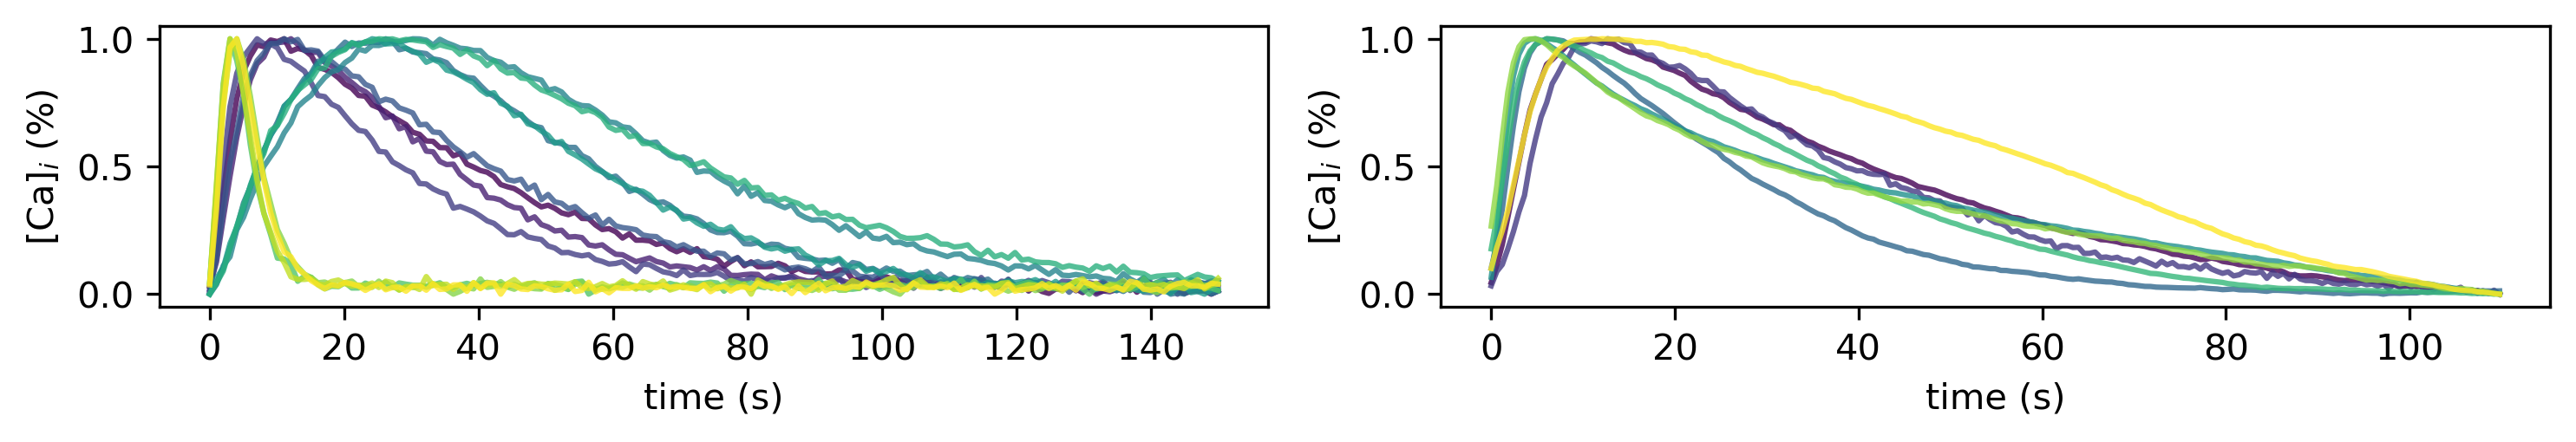

In [22]:
cmap=matplotlib.colormaps['viridis']

rcParams['figure.figsize']=10,1.8
fig=plt.figure()
for i,key in enumerate(data.keys()):
    n=nCells[key]
    gradient=np.linspace(0,1,n)
    ax=fig.add_subplot(1,2,i+1)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('[Ca]$_i$ (%)')
    for cell in range(n):
        caExpt=data[key][cell]
        stepSize=len(caExpt)
        ts=np.linspace(0,stepSize*frameRate[key],stepSize)
        yobs=caExpt
        yobs-=np.min(yobs)
        yobs/=np.max(yobs)
        ax.plot(ts,yobs,color=cmap(gradient[cell]),alpha=0.8,)
plt.tight_layout()

In [7]:
rcParams['figure.dpi']=300

In [137]:
# load inference data
path='/home/xfang2/backup/faust_backup/automagikFitting/pymc3/freq_fit/bv2'
model=1
nParams=len(params)
infData={}
infData['sim']=[]
infData['expt']=[]


for key in data.keys():
    n=nCells[key]
    
    for cell in range(n):
        ps={}
        
        for p in range(nParams):
            results=np.genfromtxt(path+'/model{}/v2/fit_results_{}_{}.csv'.format(model,key,p),delimiter=',')
            param_name=params[p]
            ps[param_name]=results[:,cell]
            
        infData[key].append(ps)


/tmp/ipykernel_17278/2867505942.py:23: RuntimeWarning: invalid value encountered in divide
  data/=np.max(data)


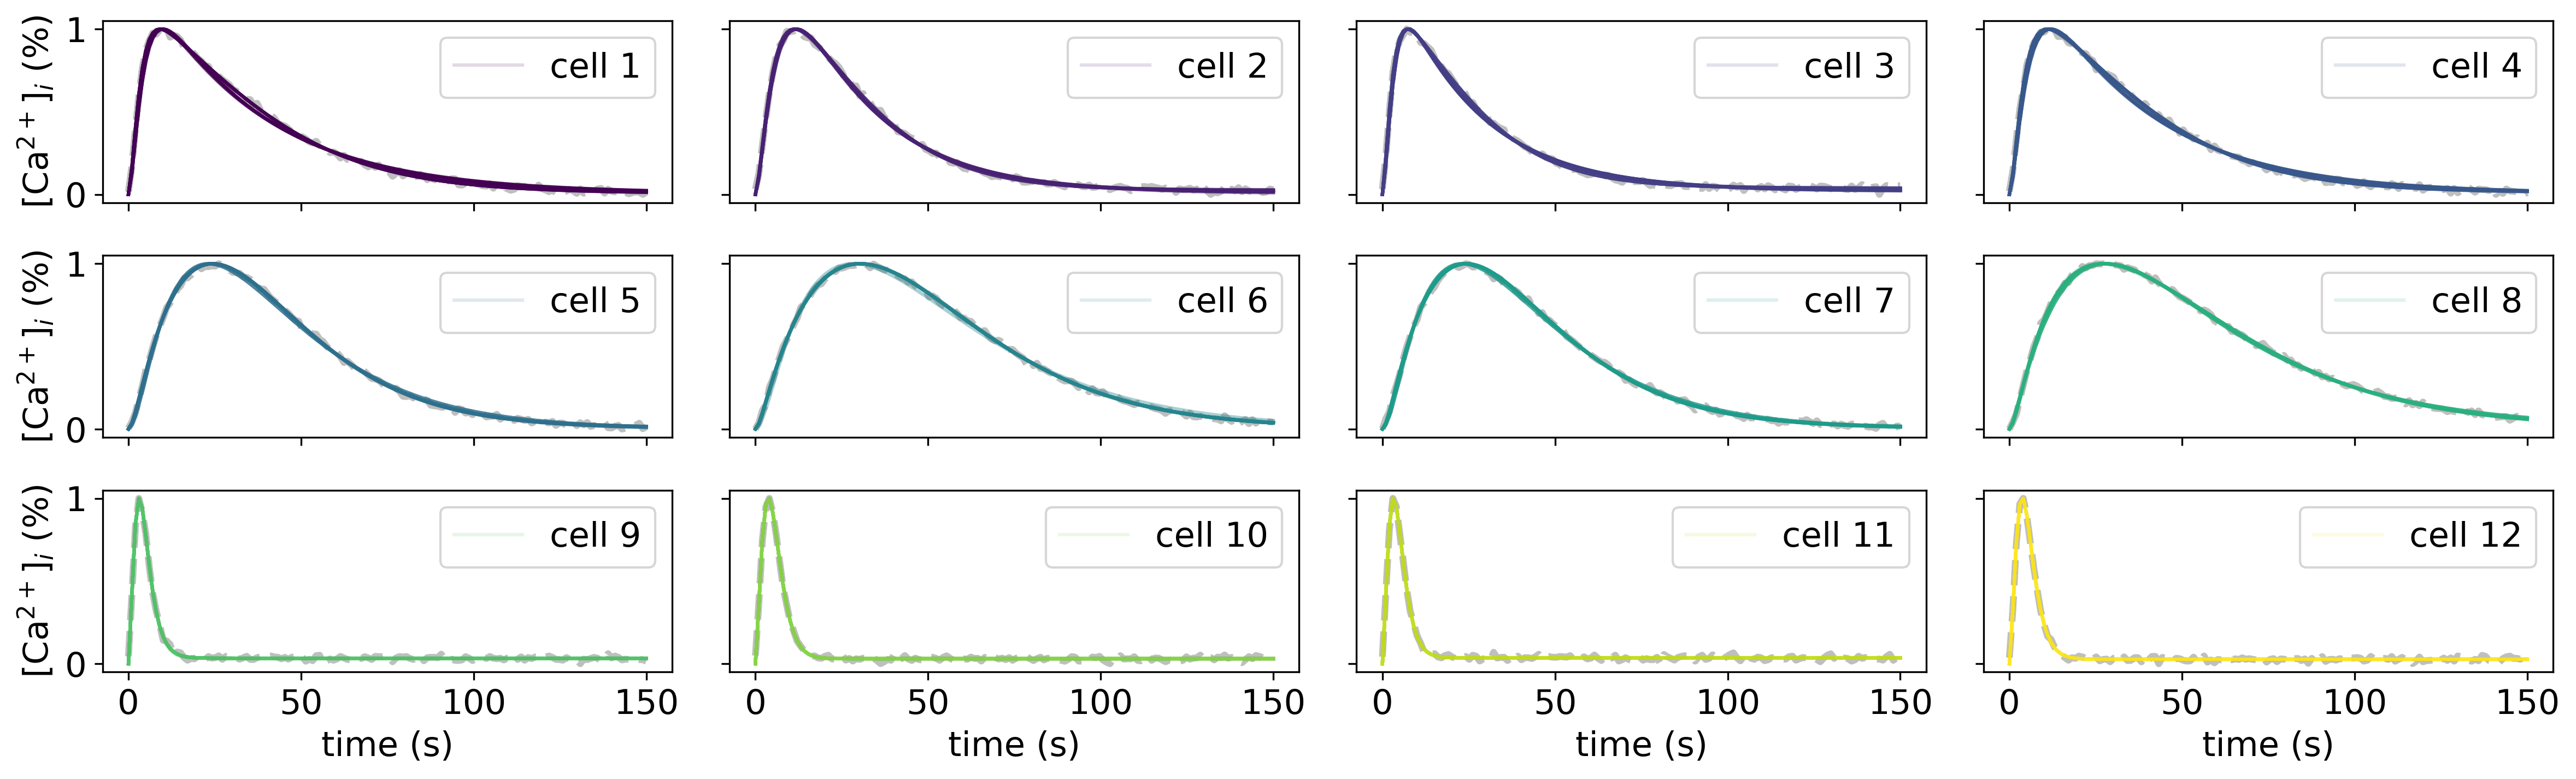

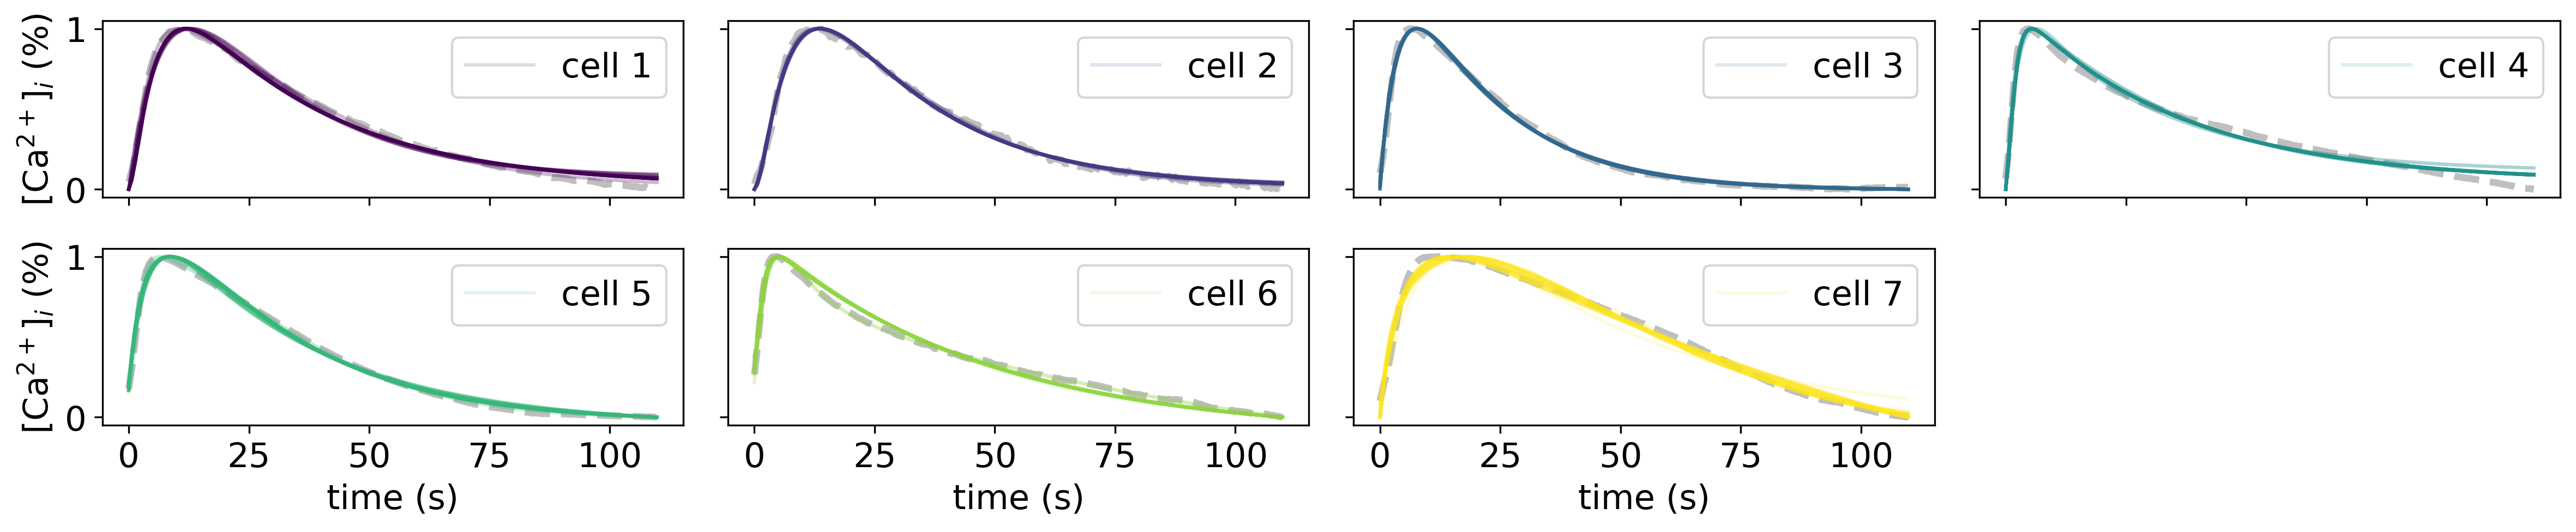

In [141]:
# fit
rcParams['font.size']=15
mses={'sim':[],
      'expt':[]}

for key in data.keys():
    if key=='expt':
        rcParams['figure.figsize']=16,3.5
        nrows,ncols=2,4
    else:
        rcParams['figure.figsize']=16,5
        nrows,ncols=3,4
    
    n=nCells[key]
    df=infData[key]
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex='col', sharey='row')
    cell=0
    gradient=np.linspace(0,1,n)
    
    for row in range(nrows):
        for col in range(ncols):
            ax = axes[row, col]       
            mse1=[]
    
            if col == 0:  # Leftmost column
                ax.set_ylabel('[Ca$^{2+}$]$_i$ (%)')
            if row == nrows - 1:  # Bottom row
                ax.set_xlabel('time (s)')
            
            try:
                channel1=data[key][cell]
            except:
                ax.set_visible(False) 
                continue
                
            channel1=minmax_scaling(channel1)
            stepSize=len(channel1)
            ts=np.linspace(0,stepSize*frameRate[key],stepSize)
            ax.plot(ts,channel1,lw=3,color='gray',alpha=0.5,linestyle='--')   

            channel1Min,channel1Max=np.min(channel1),np.max(channel1)
            y0=channel1[0]

            varDict={}
            varDict['caEx']=fixedParams[key]['caEx']
            
            for k in range(nIter):
                for i,param in enumerate(params):
                    varDict[param]=infData[key][cell][param][k]

                if key == 'sim':
                    y0s=[1.0, 0.1, y0]
                else:
                    y0s=[1.0e-2, 0.1, y0]
                ys = solve_ivp(dydt,[0,ts[-1]],y0s,args=(varDict,),t_eval=ts,method='LSODA').y
                caSim=ys[2] 
                
                # normalization
                caSim=minmax_scaling(caSim)
                caSim=caSim*(channel1Max-channel1Min)+channel1Min
                ax.plot(ts,caSim,alpha=0.15,color=cmap(gradient[cell]),label='cell {}'.format(cell+1))
                
                if k==0:
                    ax.legend(loc=0)
                    
                # MSE
                m1=np.mean((caSim-channel1)**2)
                mse1.append(m1)
            
            cell+=1
            
            mses[key].append(mse1)
            
    plt.tight_layout()
    plt.gcf().savefig('model{}_de_fit_{}.png'.format(model,key))
    
    

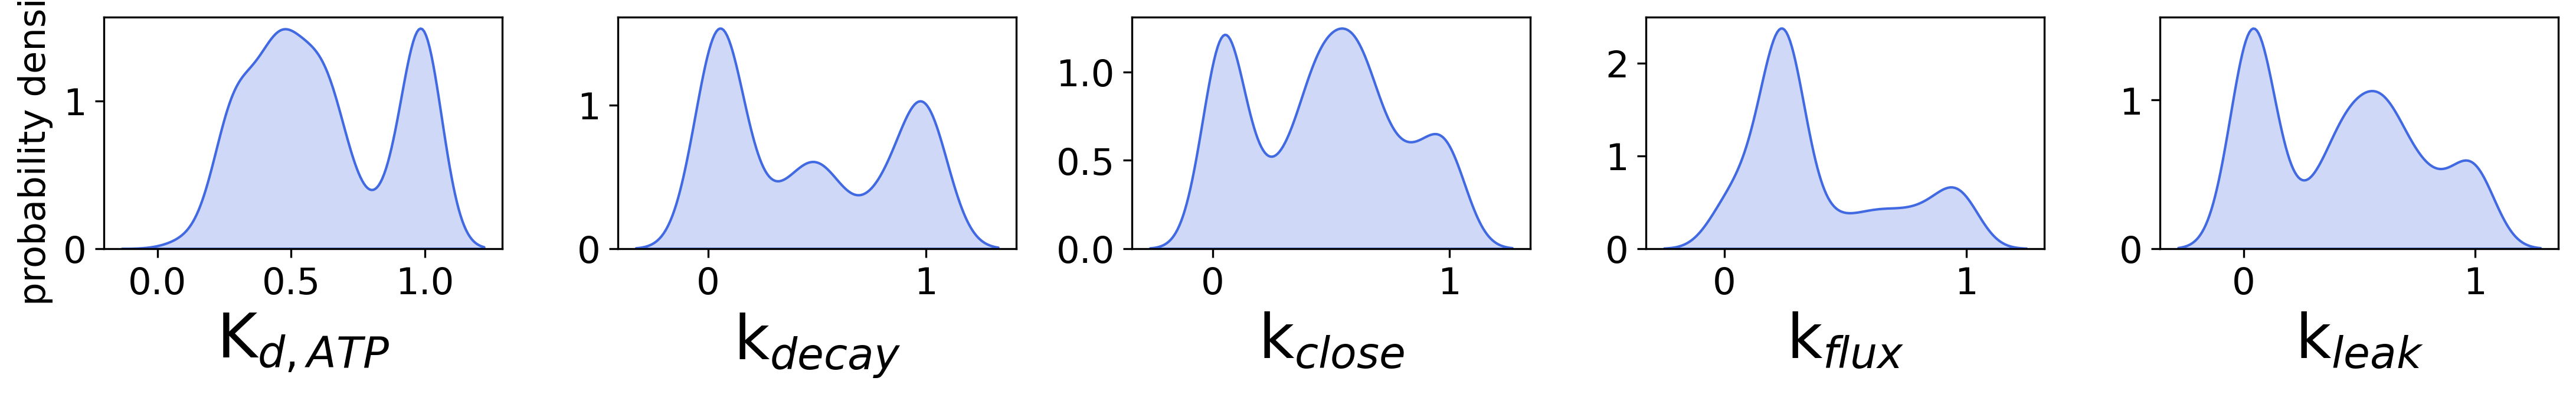

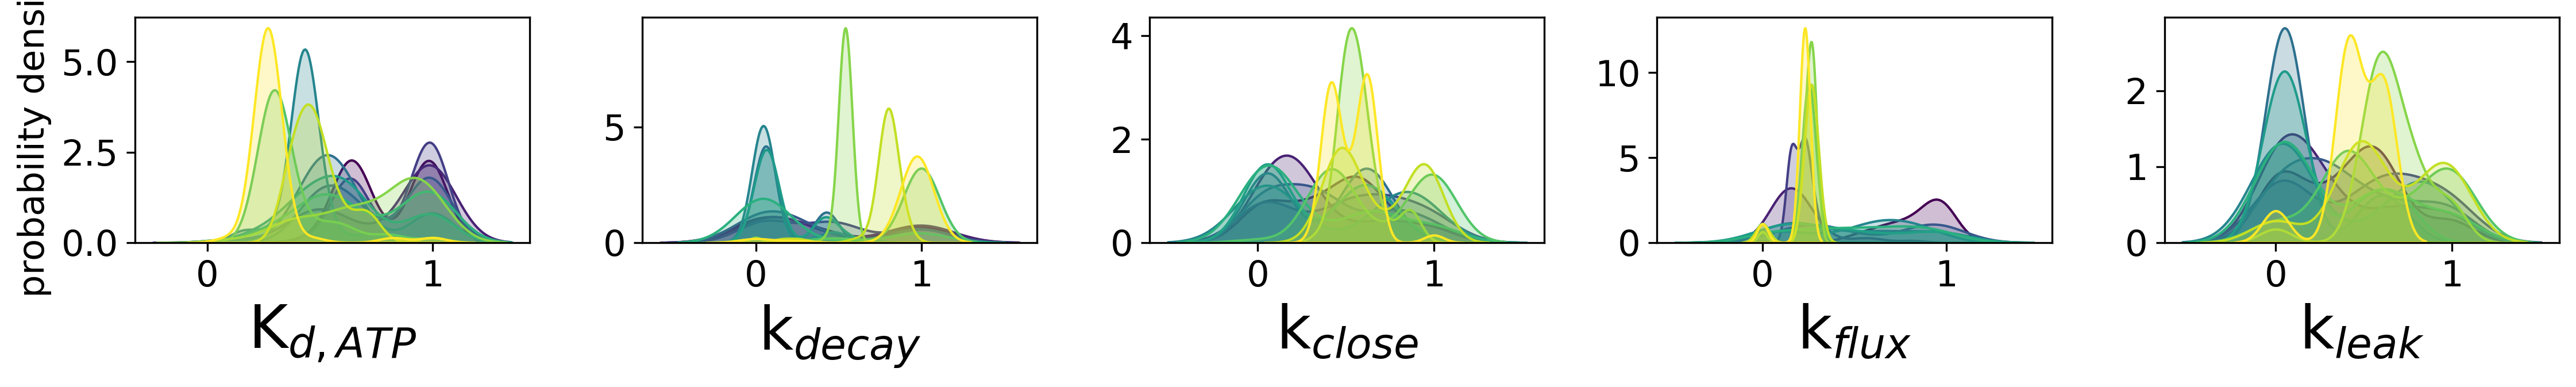

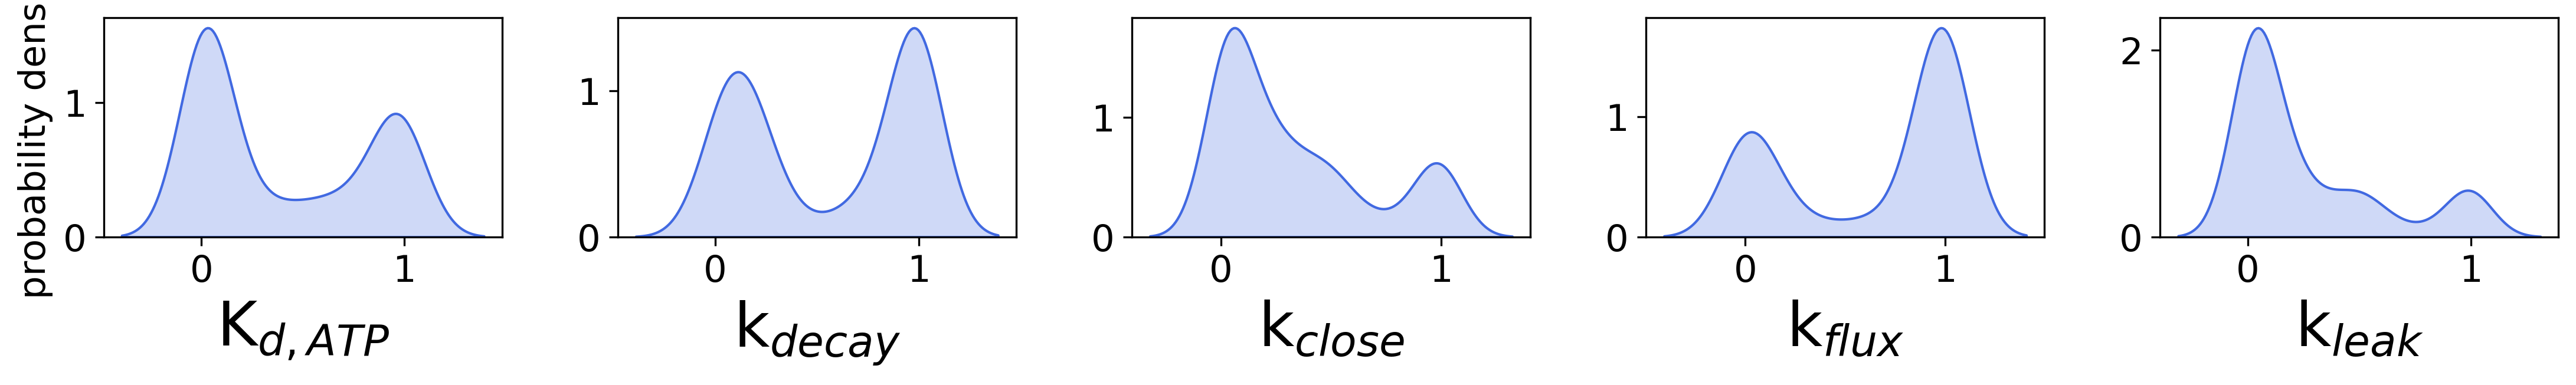

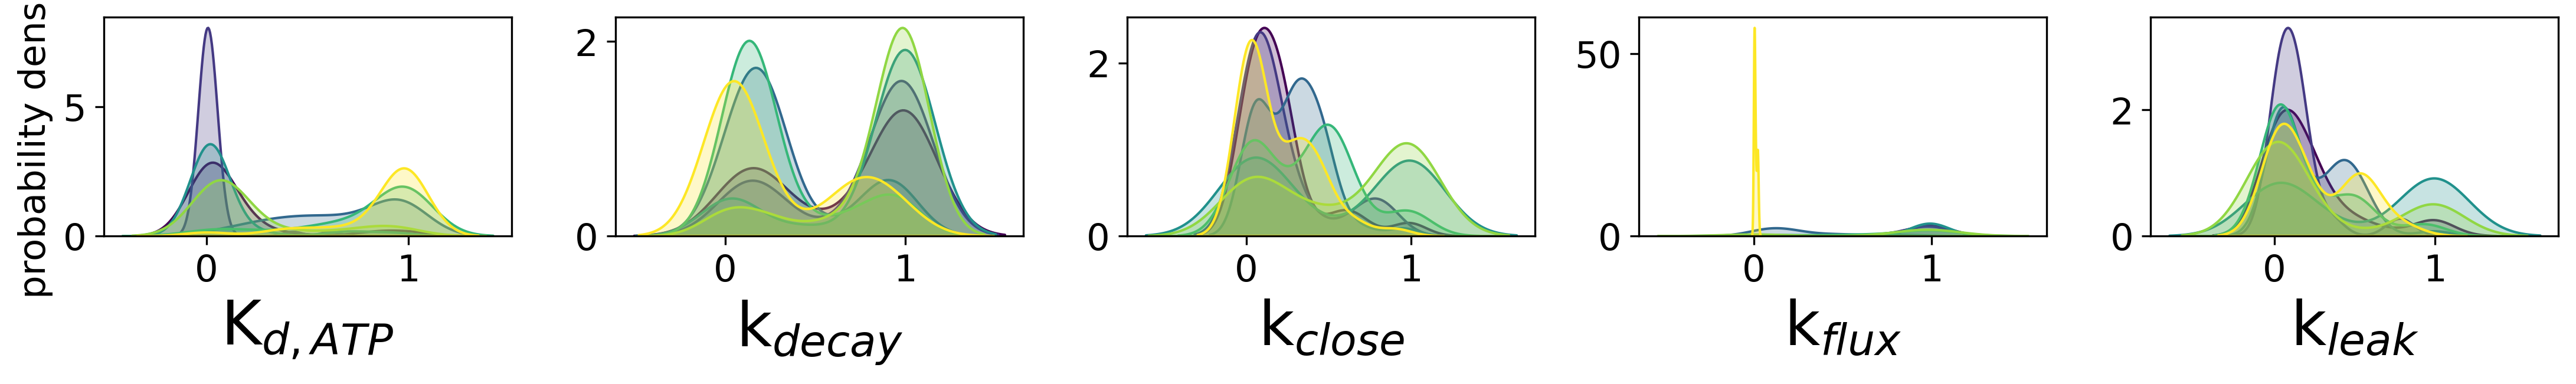

In [150]:
rcParams['font.size']=15
rcParams['figure.figsize']=15,2.5

for key in data.keys():
    fig=plt.figure()
    for i,p in enumerate(params):
        ax=fig.add_subplot(1,5,i+1)
        ax.set_xlabel(labels[i],fontsize=25)
        #ax.set_xlabel('value')

        vals=np.genfromtxt(path+'/model{}/v2/fit_results_{}_{}.csv'.format(model,key,i),delimiter=',').ravel()

        sns.kdeplot(vals,color='royalblue',fill=True).set(ylabel=None)

        if i==0:
            ax.set_ylabel('probability density')

    plt.tight_layout()
    plt.gcf().savefig('model{}_de_dist_{}.png'.format(model,key))

    
    fig=plt.figure()
    n=nCells[key]
    gradient=np.linspace(0,1,n)

    for i,param in enumerate(params):
        ax=fig.add_subplot(1,5,i+1)
        ax.set_xlabel(labels[i],fontsize=25)
        #ax.set_xlabel('value')

        for cell in range(n):
            v=infData[key][cell][param]
            sns.kdeplot(v,color=cmap(gradient[cell]),fill=True).set(ylabel=None)
            
        if i==0:
            ax.set_ylabel('probability density')

    plt.tight_layout()
    plt.gcf().savefig('model{}_de_dist_cell_{}.png'.format(model,key))

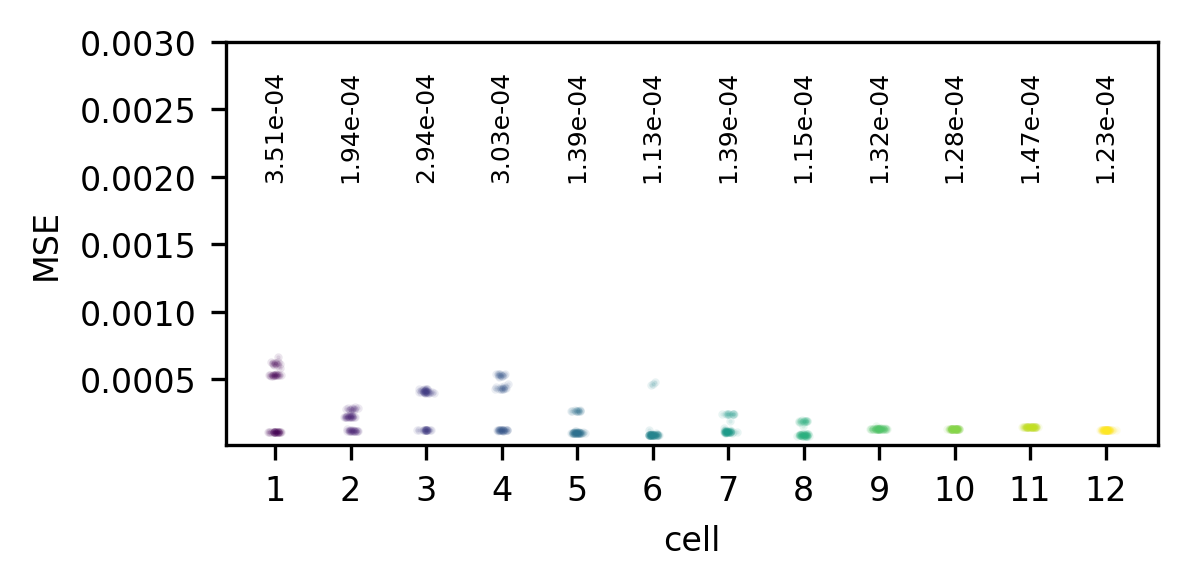

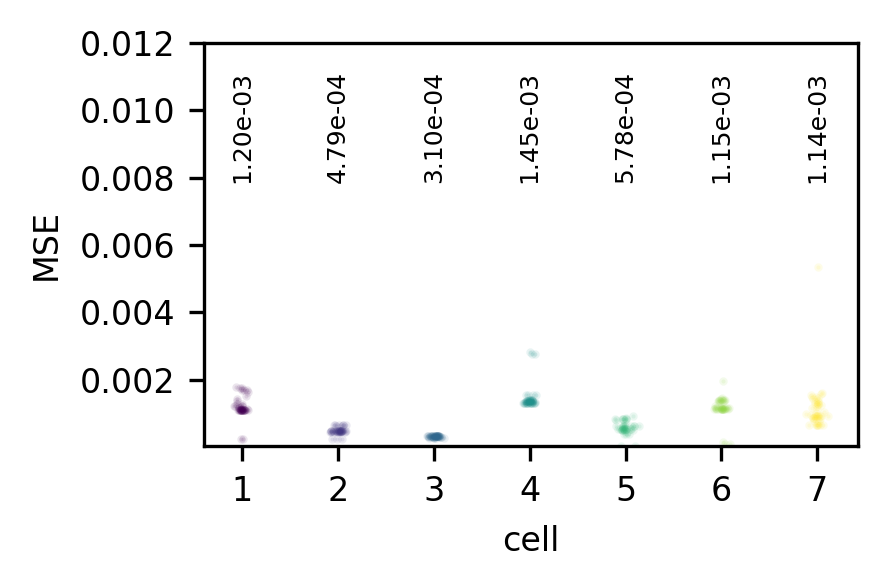

In [146]:

rcParams['font.size']=8

for i,key1 in enumerate(mses.keys()):
    if key1=='sim':
        rcParams['figure.figsize']=4,2
    else:
        rcParams['figure.figsize']=3,2
    n=nCells[key1]
    gradient=np.linspace(0,1,n)
    
    fig=plt.figure()
    
    ax=fig.add_subplot(1,1,1)
    ax.set_xlabel('cell')
    ax.set_xticks(np.arange(n+1))
    ax.set_ylabel('MSE')
    if key1 == 'sim':
        ax.set_ylim([0.00001, 0.003])
        yloc=0.002
    else:
        ax.set_ylim([0.00002, 0.012])
        yloc=0.008

    vals=mses[key1]
    parts=ax.violinplot(vals,showextrema=False)
    for i,pc in enumerate(parts['bodies']):
        pc.set_facecolor(cmap(gradient[i]))
        pc.set_alpha(0.3)
            
    for cell in range(n):
        ys=vals[cell]
        ys=np.array(ys)
        ys = ys[~np.isnan(ys)]
        xs=np.random.normal(cell+1, 0.04, len(ys))
        ax.scatter(xs,ys,s=1,color=cmap(gradient[cell]),alpha=0.1)
        
        avg=np.mean(ys)
        ax.annotate(f"{avg:.2e}", xy=(cell+1, yloc),fontsize=6,
            horizontalalignment="center",rotation=90,)

    plt.tight_layout()
    plt.gcf().savefig('model{}_de_mse_{}.png'.format(model,key))